## Max Wienandts

Problem Statement:
-  Is BERT and DistilBERT appropriate to sentiment analysis? Is Latent Dirichlet Allocation (LDA) appropriate for topic modeling?

|SUMMARY|
|:------------------------------------------------|
|[**1. LSTM for a dataset**](#LSTM_for_a_dataset)|
|[**2. Topic modelng with LDA for a dataset**](#Topic_modelng_with_LDA_for_a_dataset)|
|[**3. Sample analysis**](#Sample_analysis)|
|[**4. LSTM for a custom review**](#LSTM_for_a_custom_review)|
|[**5. Topic modelng with LDA for a custom review**](#Topic_modelng_with_LDA_for_a_custom_review)|

This project have 4 Jupyter notebook:
- 1 ETL and EDA.ipynb;
- 2 LSTM BERT DistilBERT.ipynb;
- 3 Topic modeling.ipynb; and
- 4 Production.ipynb.

They should be runned in order. \
The objective of the first notebook is to known better our dataset and to clean it. \
The second notebook have the models related to sentiment analysis. \
The third one have the topic modeling. \
Finally, the last notebook is an example to how to apply the sentiment and topic models to an dataset and to a custow review.

In [1]:
import json
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing

import re
import nltk   # It is necessary to have to download 'stopwords' from nltk.

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Custom review to be analyzed.
custom_review = "It's good but it's also bad. I don't know. Maybe they could train better the management."

# Operational system. If Linux "1", otherwise "0".
OS_system = 0

# Path to load word to index file used in the baseline LSTM model
word2idx_base_LSTM_path_win = r"C:\Users\maxwi\Python\Harvard\Electives\1 CSCI S-89 Introduction to Deep Learning\Project\1 sentiment analysis\Glassdoor 2\models\base_LSTM\word2idx.txt"
word2idx_base_LSTM_path_linux = "/home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/base_LSTM/model_base_LSTM"

# Epochs used in the best LSTM model
base_LSTM_epoch_best_metric = 3
# Path to load baseline LSTM model
base_LSTM_path_win = r"C:\Users\maxwi\Python\Harvard\Electives\1 CSCI S-89 Introduction to Deep Learning\Project\1 sentiment analysis\Glassdoor 2\models\base_LSTM\model_base_LSTM"
base_LSTM_path_linux = "/home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/base_LSTM/model_base_LSTM"

# Path to save model
LDA_path_win = r"C:\Users\maxwi\Python\Harvard\Electives\1 CSCI S-89 Introduction to Deep Learning\Project\1 sentiment analysis\Glassdoor 2\models\LDA\LDA_model.pk"
LDA_path_linux = "/home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/LDA/LDA_model.pk"

tfidf_path_win = r"C:\Users\maxwi\Python\Harvard\Electives\1 CSCI S-89 Introduction to Deep Learning\Project\1 sentiment analysis\Glassdoor 2\models\LDA\tfidf.pk"
tfidf_path_linux = "/home/max/Python/Harvard/Electives/1 CSCI S-89 Introduction to Deep Learning/Project/1 sentiment analysis/Glassdoor 2/models/LDA/tfidf.pk"


if OS_system == 1:
    word2idx_base_LSTM_path = word2idx_base_LSTM_path_linux
    base_LSTM_path = base_LSTM_path_linux
    LDA_path = LDA_path_linux
    tfidf_path = tfidf_path_linux

else:
    word2idx_base_LSTM_path = word2idx_base_LSTM_path_win
    base_LSTM_path = base_LSTM_path_win
    LDA_path = LDA_path_win
    tfidf_path = tfidf_path_win

In [3]:
df = pd.read_csv('df_sample.csv', usecols = ['firm', 'pros', 'cons'])
# Preprocess
# Rename columns so pros = 1, cons = 0
df.columns = ['firm', '1', '0']

# Put the reviews in only one column and create a target column expressing if the review is positive or negative.
df = pd.melt(df, id_vars=['firm'], value_vars=['1', '0'])
df.columns = ['firm', 'target', 'review']
df = df[['firm', 'review']]  # This time, the column target is not needed.

# Before doing any study in our data, lets anonymize the company names.
label_acoder = preprocessing.LabelEncoder()  
label_acoder.fit(df.firm)  # We are not useing the same model in training because this is just to anonimize the companies names.
df.firm = label_acoder.transform(df.firm)

df.head()

,firm,review
0,172,Resources. Plenty of experienced people to hel...
1,220,Excellent company! Great Training! Great Culture
2,229,company has a good atmosphere of technically s...
3,229,new technology to work on and brand name
4,182,WaMu had a very diverse group of people to wor...


<div id='LSTM_for_a_dataset' />

## LSTM for a dataset
Classify reviews as postive or negative.

In [4]:
# Preprocess for LSTM.
X_prod = df['review']
# Remove punctuations.
X_prod = X_prod.replace({r'[^\w\s]': ' '}, regex = True)

# Load word2idx
# Opening JSON file
with open(word2idx_base_LSTM_path) as json_file:
    word2idx = json.load(json_file)

# Encode the sentences
def encode_row(review, word2idx):
    ecoded_row = []
    for word in str(review).split():
        if word in word2idx:
            ecoded_row.append(word2idx[word])
        else:
            ecoded_row.append(word2idx["<UNK>"])
    return ecoded_row

X_prod_encoded = []
for review in X_prod:
    econded_review = encode_row(review, word2idx)
    X_prod_encoded.append(econded_review)

# PAD reviews
max_len = 60 # Using a max length of 60, we get more than 95% of the reviews.
X_prod_encoded = pad_sequences(X_prod_encoded, maxlen = max_len, padding = 'pre')

In [5]:
# Load best saved model
if base_LSTM_epoch_best_metric > 9:
    best_epoch_aux = "_00" + str(base_LSTM_epoch_best_metric)
else:
    best_epoch_aux = "_000" + str(base_LSTM_epoch_best_metric)
best_base_LSTM_path_win = base_LSTM_path_win + best_epoch_aux + ".h5"
best_base_LSTM_path_linux = base_LSTM_path_linux + best_epoch_aux + ".h5"
if OS_system == 1:
    best_base_LSTM_path = best_base_LSTM_path_linux
else:
    best_base_LSTM_path = best_base_LSTM_path_win
model_base_LSTM = tf.keras.models.load_model(best_base_LSTM_path, compile = False)

# Predict
y_pred_proba = model_base_LSTM.predict(X_prod_encoded)
y_pred = ['Positive' if x > 0.5 else 'Negative' for x in y_pred_proba]

# Add prediction in dataset
df['sentiment_review'] = y_pred

sentiment_proportion = df['sentiment_review'].value_counts(normalize = True)[0]*100
print(f'{sentiment_proportion: 0.2f}% of the reviews are positive.')

2621/2621 [==============================] - 10s 2ms/step
 50.20% of the reviews are positive.


<div id='Topic_modelng_with_LDA_for_a_dataset' />
    
## Topic modelng with LDA for a dataset

In [6]:
# Preprocess
# Substitute /r and /n by space
df.replace({ '\r': ' ', '\n' : ' '}, regex = True, inplace = True)

# Lower case
df['review_lower'] = df.review.str.lower()

# Remove punctuation
df['review_lower'].replace({r'[^\w\s]': ' '}, regex = True, inplace = True)

# Remove rows with only whitespaces
df = df.replace(r'^\s*$', np.nan, regex = True).dropna()
df = df.replace('', np.nan, regex = True).dropna()

# Remove stop words
stopwords = nltk.corpus.stopwords.words('english')
# Include new stopwords not useful for this project in specific.
new_stopwords = ['able', 'across', 'alway', 'always', 'amazing', 'amount', 'around', 'available', 'average', 'away'
                 , 'back', 'bad', 'bank', 'best', 'better', 'big', 'bit'
                 , 'call', 'care', 'certain', 'co', 'come', 'comme', 'con', 'cons', 'cost'
                 , 'day', 'decent', 'different', 'difficult', 'done', 'due'
                 , 'easy', 'end', 'enough', 'especially', 'etc', 'even', 'event', 'every', 'everything', 'excellent', 'extremely'
                 , 'fantastic', 'far', 'fast', 'feel', 'few', 'find', 'firm', 'first', 'focu', 'full'
                 , 'getting', 'give', 'given', 'go', 'going', 'good', 'great'
                 , 'hard', 'high', 'higher', 'interesting', 'keep', 'know'
                 , 'lack', 'late', 'leave', 'less', 'level', 'limited', 'little', 'long', 'lot', 'lots', 'low', 'lower'
                 , 'made', 'make', 'may', 'many', 'meet', 'meeting', 'middle', 'might', 'month', 'months', 'much'
                 , 'n', 'name', 'need', 'never', 'new', 'non', 'number'
                 , 'often', 'old', 'one', 'open', 'other', 'others', 'overall'
                 , 'part', 'pretty', 'poor', 'put', 'quality', 'quite', 'rather', 'real', 'really', 'right' , 'room'
                 , 'say', 'seem', 'short', 'slow', 'smart', 'sometime', 'sometimes', 'standard', 'start', 'still', 'strong'
                 , 'take', 'term', 'thing', 'things', 'though', 'think', 'top', 'tough', 'u', 'unless'
                 , 'want', 'way', 'week', 'well', 'within', 'without', 'world', 'year', 'years']
for e in new_stopwords:
    stopwords.append(e)
df['review_without_stopwords'] = df['review_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

# Tokenize words. Used to make it easier to stem.
df['review_token'] = df['review_without_stopwords'].apply(lambda x: x.split())

# stem words. This will be used in for the topic modeling.
def stem_words(vec_words):
    porter_stemmer = nltk.stem.PorterStemmer()
    vec_stemming_word = []
    for word in vec_words:
        vec_stemming_word.append(porter_stemmer.stem(word))
    return vec_stemming_word

df['review_token'] = df.apply(lambda row: stem_words(row['review_token']), axis = 1) 

# Join words to vectorize it using TF-IDF 
df['review_clean'] = df['review_token'].apply(' '.join)

# Load TF-IDF
tfidf = pickle.load(open(tfidf_path, 'rb'))

# Fit and Transform the documents
text_data = tfidf.transform(df['review_clean'])

In [7]:
# Load model
lda_best_model = pickle.load(open(LDA_path, 'rb'))

# Apply model in dataset
lda_predict = lda_best_model.transform(text_data)

# Select the most relevant topic
lda_predict_first_topic = []
for e in lda_predict:
    first_topic_number = np.argmax(e)
    if first_topic_number == 0:
        lda_predict_first_topic.append('Compensation and Benefits')
    elif first_topic_number == 1:
        lda_predict_first_topic.append('Staff')
    elif first_topic_number == 2:
        lda_predict_first_topic.append('Senior Management')
    else:
        lda_predict_first_topic.append('Work/Life Balance')

# Add the topics in  the dataset
df['first_LDA_topics'] = lda_predict_first_topic

df = df[['firm', 'review', 'sentiment_review', 'first_LDA_topics']]
df.head()

,firm,review,sentiment_review,first_LDA_topics
0,172,Resources. Plenty of experienced people to hel...,Positive,Senior Management
1,220,Excellent company! Great Training! Great Culture,Positive,Work/Life Balance
2,229,company has a good atmosphere of technically s...,Positive,Work/Life Balance
3,229,new technology to work on and brand name,Positive,Work/Life Balance
4,182,WaMu had a very diverse group of people to wor...,Positive,Senior Management


<div id='Sample_analysis' />
    
## Sample analysis

In [8]:
def bar_graph_categoric_var(df_variable, title, rotation = 0, limite_categorias = 50, alphabetic_order = False):
    plt.rcParams.update(plt.rcParamsDefault)
    color = 'cornflowerblue'
    contorno = None
    if alphabetic_order == True:
        df_bar_graph = pd.DataFrame(df_variable.value_counts()).sort_index().head(limite_categorias)
    else:
        df_bar_graph = pd.DataFrame(df_variable.value_counts()).head(limite_categorias)
    ax = df_bar_graph.plot(kind = 'bar', width = 0.5, rot = rotation
                          , align = 'center', color = color, edgecolor = contorno)
    ax.get_legend().remove()
    total = 0
    for bars in ax.patches:
        total += bars.get_height()
       
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height/total:.1%}'
                    , (x + width/2, y + 2 + height)
                    , ha = 'center')
        plt.title(title, fontsize = 10)

    plt.show()
    plt.close()

,count,%
sentiment_review,,
Positive,3044,0.503057
Negative,3007,0.496943


<Figure size 600x300 with 0 Axes>

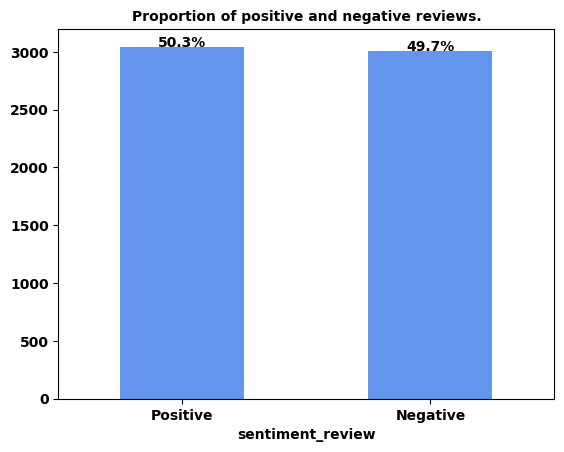

In [9]:
# Get a firm as example
firm_number = 172  # This is the firm with most reviews
df_analysis = df[np.in1d(df.firm, firm_number)].copy()
# Proportion of positive and negative reviews
value_counts = pd.DataFrame(df_analysis['sentiment_review'].value_counts(dropna = False))
value_counts['%'] = value_counts['count'] / sum(value_counts['count'])
display(value_counts)
# Plot
plt.figure(figsize = (6,3))
df_variable = df_analysis['sentiment_review']
title = 'Proportion of positive and negative reviews.'
bar_graph_categoric_var(df_variable, title, rotation = 0, limite_categorias = 15)

Proportion of topics for positive reviews.:


,count,%
first_LDA_topics,,
Work/Life Balance,1511,0.496386
Senior Management,763,0.250657
Compensation and Benefits,538,0.176741
Staff,232,0.076216


<Figure size 600x300 with 0 Axes>

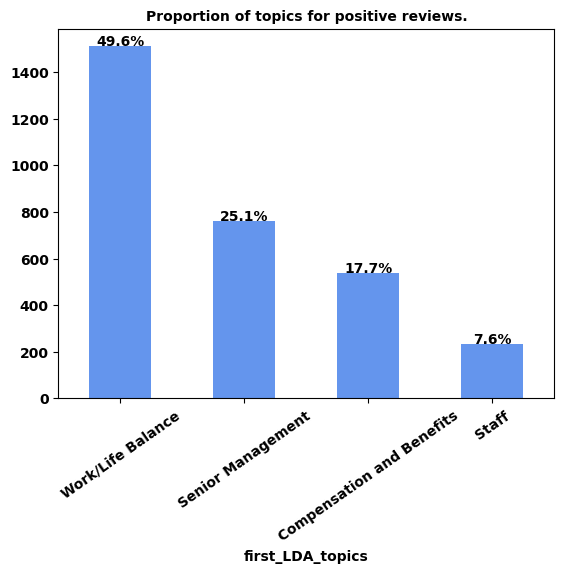

In [10]:
# Verify topics of positive reviews
df_analysis_positive = df_analysis[np.in1d(df_analysis.sentiment_review, 'Positive')]
# Proportion of topics for positive reviews.
print('Proportion of topics for positive reviews.:')
value_counts = pd.DataFrame(df_analysis_positive['first_LDA_topics'].value_counts(dropna = False))
value_counts['%'] = value_counts['count'] / sum(value_counts['count'])
display(value_counts)
# Plot
plt.figure(figsize = (6,3))
df_variable = df_analysis_positive['first_LDA_topics']
title = 'Proportion of topics for positive reviews.'
bar_graph_categoric_var(df_variable, title, rotation = 35, limite_categorias = 15)

Proportion of topics for negative reviews.:


,count,%
first_LDA_topics,,
Senior Management,1714,0.570003
Compensation and Benefits,775,0.257732
Work/Life Balance,283,0.094114
Staff,235,0.078151


<Figure size 600x300 with 0 Axes>

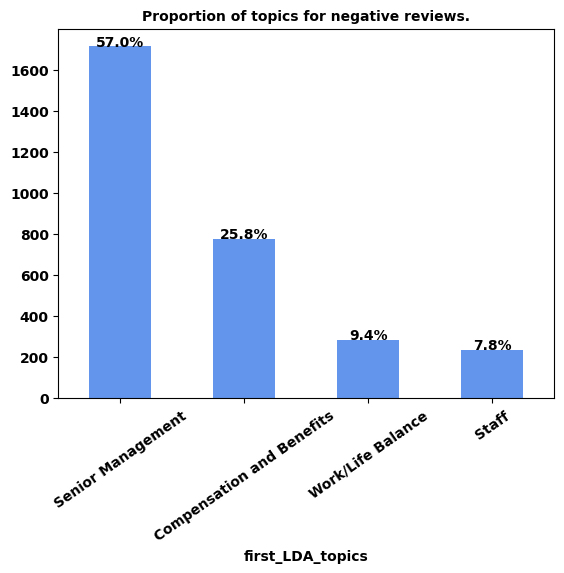

In [11]:
# Verify topics of positive reviews
df_analysis_negative = df_analysis[np.in1d(df_analysis.sentiment_review, 'Negative')]
# Proportion of topics for positive reviews.
print('Proportion of topics for negative reviews.:')
value_counts = pd.DataFrame(df_analysis_negative['first_LDA_topics'].value_counts(dropna = False))
value_counts['%'] = value_counts['count'] / sum(value_counts['count'])
display(value_counts)
# Plot
plt.figure(figsize = (6,3))
df_variable = df_analysis_negative['first_LDA_topics']
title = 'Proportion of topics for negative reviews.'
bar_graph_categoric_var(df_variable, title, rotation = 35, limite_categorias = 15)

For this specific firm, the sentiment of the reviews are well balanced between positive and negative (this was expected given the nature of our dataset). \
The most positive characteristic of working there is the work/life balance. \
On the other hand, the employees seems to have a problem with the senior management of the company.

<div id='LSTM_for_a_custom_review' />

## LSTM for a custom review

In [12]:
print(f'Review: {custom_review}')

# Preprocess for LSTM.
X_prod = custom_review
# Remove punctuations.
X_prod = re.sub(r'[^\w\s]', '', X_prod)

# Load word2idx
# Opening JSON file
with open(word2idx_base_LSTM_path) as json_file:
    word2idx = json.load(json_file)

# Encode the sentences
def encode_row(review, word2idx):
    ecoded_row = []
    for word in str(review).split():
        if word in word2idx:
            ecoded_row.append(word2idx[word])
        else:
            ecoded_row.append(word2idx["<UNK>"])
    return ecoded_row

econded_review = encode_row(X_prod, word2idx)

# PAD reviews
max_len = 60 # Using a max length of 60, we get more than 95% of the reviews.
X_prod_encoded = pad_sequences([econded_review], maxlen = max_len, padding = 'pre')

Review: It's good but it's also bad. I don't know. Maybe they could train better the management.


In [13]:
# Load model
if base_LSTM_epoch_best_metric > 9:
    best_epoch_aux = "_00" + str(base_LSTM_epoch_best_metric)
else:
    best_epoch_aux = "_000" + str(base_LSTM_epoch_best_metric)
best_base_LSTM_path_win = base_LSTM_path_win + best_epoch_aux + ".h5"
best_base_LSTM_path_linux = base_LSTM_path_linux + best_epoch_aux + ".h5"
if OS_system == 1:
    best_base_LSTM_path = best_base_LSTM_path_linux
else:
    best_base_LSTM_path = best_base_LSTM_path_win
model_base_LSTM = tf.keras.models.load_model(best_base_LSTM_path, compile = False)

# Predict
y_pred_proba = model_base_LSTM.predict(X_prod_encoded)
y_pred = ['Positive' if x > 0.5 else 'Negative' for x in y_pred_proba]

print(f'Review: {custom_review}')
print(f'Predicted sentiment: {y_pred}')

1/1 [==============================] - 0s 377ms/step
Review: It's good but it's also bad. I don't know. Maybe they could train better the management.
Predicted sentiment: ['Negative']


<div id='Topic_modelng_with_LDA_for_a_custom_review' />

## Topic modelng with LDA for a custom review

In [14]:
# Preprocess
X_prod = custom_review
# Remove punctuations.
X_prod = re.sub(r'[^\w\s]', '', X_prod)

# Substitute /r and /n by space
X_prod = re.sub('\r', ' ', X_prod)
X_prod = re.sub('\n', ' ', X_prod)

# Lower case
X_prod = X_prod.lower()

# Remove punctuation
X_prod = re.sub(r'[^\w\s]', '', X_prod)

# Remove stop words
stopwords = nltk.corpus.stopwords.words('english')
# Include new stopwords not useful for this project in specific.
new_stopwords = ['able', 'across', 'alway', 'always', 'amazing', 'amount', 'around', 'available', 'average', 'away'
                 , 'back', 'bad', 'bank', 'best', 'better', 'big', 'bit'
                 , 'call', 'care', 'certain', 'co', 'come', 'comme', 'con', 'cons', 'cost'
                 , 'day', 'decent', 'different', 'difficult', 'done', 'due'
                 , 'easy', 'end', 'enough', 'especially', 'etc', 'even', 'event', 'every', 'everything', 'excellent', 'extremely'
                 , 'fantastic', 'far', 'fast', 'feel', 'few', 'find', 'firm', 'first', 'focu', 'full'
                 , 'getting', 'give', 'given', 'go', 'going', 'good', 'great'
                 , 'hard', 'high', 'higher', 'interesting', 'keep', 'know'
                 , 'lack', 'late', 'leave', 'less', 'level', 'limited', 'little', 'long', 'lot', 'lots', 'low', 'lower'
                 , 'made', 'make', 'may', 'many', 'meet', 'meeting', 'middle', 'might', 'month', 'months', 'much'
                 , 'n', 'name', 'need', 'never', 'new', 'non', 'number'
                 , 'often', 'old', 'one', 'open', 'other', 'others', 'overall'
                 , 'part', 'pretty', 'poor', 'put', 'quality', 'quite', 'rather', 'real', 'really', 'right' , 'room'
                 , 'say', 'seem', 'short', 'slow', 'smart', 'sometime', 'sometimes', 'standard', 'start', 'still', 'strong'
                 , 'take', 'term', 'thing', 'things', 'though', 'think', 'top', 'tough', 'u', 'unless'
                 , 'want', 'way', 'week', 'well', 'within', 'without', 'world', 'year', 'years']
for e in new_stopwords:
    stopwords.append(e)
    
X_prod = ' '.join([word for word in X_prod.split() if word not in (stopwords)])

# Tokenize words. Used to make it easier to stem.
X_prod = X_prod.split()

# stem words. This will be used in for the topic modeling.
def stem_words(vec_words):
    porter_stemmer = nltk.stem.PorterStemmer()
    vec_stemming_word = []
    for word in vec_words:
        vec_stemming_word.append(porter_stemmer.stem(word))
    return vec_stemming_word

X_prod = stem_words(X_prod)

# Join words to vectorize it using TF-IDF 
X_prod = ' '.join(X_prod)

# Load TF-IDF
tfidf = pickle.load(open(tfidf_path, 'rb'))

# Fit and Transform the documents
X_prod = tfidf.transform([X_prod])

In [15]:
# Load model
lda_best_model = pickle.load(open(LDA_path, 'rb'))

# Apply model in dataset
lda_predict = lda_best_model.transform(X_prod)

# Select the most relevant topic
lda_predict_first_topic = []
for e in lda_predict:
    first_topic_number = np.argmax(e)
    if first_topic_number == 0:
        lda_predict_first_topic.append('Compensation and Benefits')
    elif first_topic_number == 1:
        lda_predict_first_topic.append('Staff')
    elif first_topic_number == 2:
        lda_predict_first_topic.append('Senior Management')
    else:
        lda_predict_first_topic.append('Work/Life Balance')

print(f'Review: {custom_review}')
print(f'Predicted sentiment: {y_pred}')
print(f'Predicted topic: {lda_predict_first_topic[0]}')

Review: It's good but it's also bad. I don't know. Maybe they could train better the management.
Predicted sentiment: ['Negative']
Predicted topic: Compensation and Benefits
